<a href="https://colab.research.google.com/github/Yang-yamper/practice-for-graduation/blob/main/%E3%81%8B%E3%82%8B%E3%81%9F%E5%88%A4%E5%88%A5%E6%A9%9F%EF%BC%88%E8%A9%A6%E4%BD%9CverVGG%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from PIL import Image
import os, glob
import numpy as np
import random, math

#画像が保存されているルートディレクトリのパス
root_dir = "/content/drive/MyDrive/result_range"
# 商品名
categories = ["left","right"]

# 画像データ用配列
X = []
# ラベルデータ用配列
Y = []

#画像データごとにadd_sample()を呼び出し、X,Yの配列を返す関数
def make_sample(files):
    global X, Y
    X = []
    Y = []
    for cat, fname in files:
        add_sample(cat, fname)
    return np.array(X), np.array(Y)

#渡された画像データを読み込んでXに格納し、また、
#画像データに対応するcategoriesのidxをY格納する関数
def add_sample(cat, fname):
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((224,224))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

#全データ格納用配列
allfiles = []

#カテゴリ配列の各値と、それに対応するidxを認識し、全データをallfilesにまとめる
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

#シャッフル後、学習データと検証データに分ける
random.shuffle(allfiles)
th = math.floor(len(allfiles) * 0.8)
train = allfiles[0:th]
test  = allfiles[th:]
X_train, y_train = make_sample(train)
X_test, y_test = make_sample(test)
xy = (X_train, X_test, y_train, y_test)
#データを保存する（データの名前を「tea_data.npy」としている）
np.save("/content/drive/MyDrive/test_caruta.npy", xy)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


モデルの構築

In [3]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(16,(3,3),activation="relu",input_shape=(224,224,3)))
model.add(layers.Conv2D(16,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))#strides=(2,2)
model.add(layers.Conv2D(16,(3,3),activation="relu"))
model.add(layers.Conv2D(16,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.Conv2D(32,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256,activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation="sigmoid")) #分類先の種類分設定

#モデル構成の確認
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 16)      2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 16)       0         
 2D)                                                    

モデルのコンパイル

In [4]:
from tensorflow.keras.optimizers import SGD

model.compile(loss="categorical_crossentropy",optimizer=SGD(lr=0.01, momentum=0.1, decay=0.0),metrics=["acc"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


モデルの正規化

In [5]:
from keras.utils import np_utils
import numpy as np

categories = ["left","right"]
nb_classes = len(categories)

X_train, X_test,y_train, y_test = np.load("/content/drive/MyDrive/test_caruta.npy", allow_pickle=True)

#データの正規化
X_train = X_train.astype("float") / 255
X_test  = X_test.astype("float")  / 255

#kerasで扱えるようにcategoriesをベクトルに変換
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test  = np_utils.to_categorical(y_test, nb_classes)

モデルの学習

In [6]:
model = model.fit(X_train,
                  y_train,
                  epochs=30,
                  batch_size=20,
                  validation_data=(X_test,y_test))

Epoch 1/30
59/59 [==============================] - 112s 2s/step - loss: 0.6908 - acc: 0.5488 - val_loss: 0.6877 - val_acc: 0.5616
Epoch 2/30
59/59 [==============================] - 110s 2s/step - loss: 0.6883 - acc: 0.5522 - val_loss: 0.6860 - val_acc: 0.5616
Epoch 3/30
59/59 [==============================] - 111s 2s/step - loss: 0.6875 - acc: 0.5522 - val_loss: 0.6855 - val_acc: 0.5616
Epoch 4/30
59/59 [==============================] - 109s 2s/step - loss: 0.6877 - acc: 0.5522 - val_loss: 0.6854 - val_acc: 0.5616
Epoch 5/30
59/59 [==============================] - 109s 2s/step - loss: 0.6871 - acc: 0.5522 - val_loss: 0.6850 - val_acc: 0.5616
Epoch 6/30
59/59 [==============================] - 110s 2s/step - loss: 0.6875 - acc: 0.5522 - val_loss: 0.6850 - val_acc: 0.5616
Epoch 7/30
59/59 [==============================] - 109s 2s/step - loss: 0.6866 - acc: 0.5522 - val_loss: 0.6845 - val_acc: 0.5616
Epoch 8/30
59/59 [==============================] - 109s 2s/step - loss: 0.6871 - a

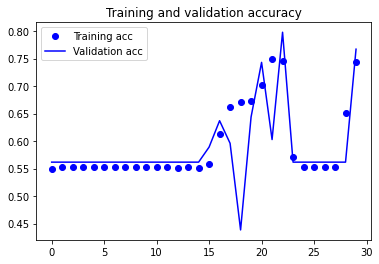

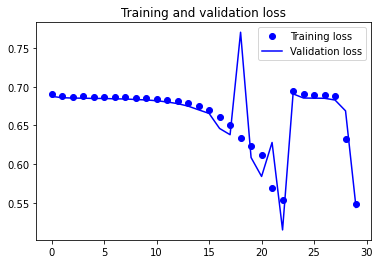

In [7]:
import matplotlib.pyplot as plt

acc = model.history['acc']
val_acc = model.history['val_acc']
loss = model.history['loss']
val_loss = model.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('property')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss')

In [ ]:
#モデルの保存

json_string = model.model.to_json()
open('/content/drive/MyDrive/caruta_predict.json', 'w').write(json_string)

#重みの保存

hdf5_file = "/content/drive/MyDrive/caruta_predict.hdf5"
model.model.save(hdf5_file)

In [ ]:
from PIL import Image
import os, glob
import numpy as np
import random, math

# 画像が保存されているディレクトリのパス
root_dir = "/content/drive/MyDrive/result_range"
# 画像が保存されているフォルダ名
categories =["left","right"]

X = [] # 画像データ
Y = [] # ラベルデータ

# フォルダごとに分けられたファイルを収集
#（categoriesのidxと、画像のファイルパスが紐づいたリストを生成）
allfiles = []
for idx, cat in enumerate(categories):
    image_dir = root_dir + "/" + cat
    files = glob.glob(image_dir + "/*.jpg")
    for f in files:
        allfiles.append((idx, f))

for cat, fname in allfiles:
    img = Image.open(fname)
    img = img.convert("RGB")
    img = img.resize((224,224))
    data = np.asarray(img)
    X.append(data)
    Y.append(cat)

x = np.array(X)
y = np.array(Y)

np.save("/content/drive/MyDrive/tea_data_test_X_150.npy", x)
np.save("/content/drive/MyDrive/tea_data_test_Y_150.npy", y)

In [ ]:
# モデルの精度を測る

#評価用のデータの読み込み
test_X = np.load("/content/drive/MyDrive/tea_data_test_X_150.npy")
test_Y = np.load("/content/drive/MyDrive/tea_data_test_Y_150.npy")

#Yのデータをone-hotに変換
from keras.utils import np_utils

test_Y = np_utils.to_categorical(test_Y, 2)

score = model.model.evaluate(x=test_X,y=test_Y)

print('loss=', score[0])
print('accuracy=', score[1])

ValueError: ignored